# Duplicate Question Pair Analysis Pipeline
This notebook continues from the previous EDA, focusing on feature engineering and modeling for duplicate question detection. The pipeline includes feature extraction, model training, evaluation and analysis of results.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from rapidfuzz.distance import Levenshtein
import spacy
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import cross_val_score
from sentence_transformers import SentenceTransformer

In [ ]:
# Download the English model for spaCy
!python -m spacy download en_core_web_sm

# Set up tqdm for pandas
tqdm.pandas()

# Set display options for pandas
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_rows', 100)

Reminder: Run the EDA notebook first to generate the cleaned dataset.

In [ ]:
# Read the cleaned version
df = pd.read_csv('quora_cleaned.csv')

# Ensure all values are strings, and fill NaNs
df['question1_transformer'] = df['question1_transformer'].fillna('').astype(str)
df['question2_transformer'] = df['question2_transformer'].fillna('').astype(str)
df['question1_light'] = df['question1_light'].fillna('').astype(str)
df['question2_light'] = df['question2_light'].fillna('').astype(str)
df['question1_squeaky'] = df['question1_squeaky'].fillna('').astype(str)
df['question2_squeaky'] = df['question2_squeaky'].fillna('').astype(str)

## Step 1: Feature Engineering
To effectively identify duplicate questions, we extract a diverse set of features capturing lexical, semantic and syntactic similarities between the pairs. Here we define the functions that generate the features themselves, returning either a series to append to a dataframe or a dataframe to concatenate with.

In [ ]:
# --- Feature: Common Word Count ---
def common_words_count(q1, q2):
    return len(set(q1.split()) & set(q2.split()))

def common_word_count(df, col1='question1_squeaky', col2='question2_squeaky'):
    return df.progress_apply(lambda row: common_words_count(row[col1], row[col2]), axis=1)


# --- Feature: Jaccard Similarity ---
def jaccard_similarity(q1, q2):
    w1 = set(q1.split())
    w2 = set(q2.split())
    union = w1 | w2
    if not union:
        return 0.0
    return len(w1 & w2) / len(union)

def jaccard(df, col1='question1_squeaky', col2='question2_squeaky'):
    return df.progress_apply(lambda row: jaccard_similarity(row[col1], row[col2]), axis=1)


# --- Feature: transformer embeddings ---
def transformer_features(df, model_class, col1='question1_transformer', col2='question2_transformer'):
    model = SentenceTransformer(model_class)
    q1_embeddings = model.encode(df[col1].tolist(), show_progress_bar=True)
    q2_embeddings = model.encode(df[col2].tolist(), show_progress_bar=True)
    # Calculate features
    cosine_sims = []
    dot_products = []
    abs_diffs = []
    for q1, q2 in tqdm(zip(q1_embeddings, q2_embeddings), total=len(df), desc=f"Computing features for {model_class}"):
        cosine_sims.append(cosine_similarity([q1], [q2])[0][0])
        dot_products.append(np.dot(q1, q2))
        abs_diffs.append(np.mean(np.abs(q1 - q2)))
    # Column names
    cos_sim_col = f"{model_class}_cosine_sim"
    dot_prod_col = f"{model_class}_dot_prod"
    abs_diff_col = f"{model_class}_abs_diff_mean"
    # Return as DataFrame
    return pd.DataFrame({
        cos_sim_col: cosine_sims,
        dot_prod_col: dot_products,
        abs_diff_col: abs_diffs
    }, index=df.index)


# --- Feature: TF-IDF vectors  ---
def tfidf_features(df, col1='question1_squeaky', col2='question2_squeaky', max_features=10000, min_df=1):
    # Fit vectorizer once on combined data
    all_text = pd.concat([df[col1], df[col2]], ignore_index=True)
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    vectorizer.fit(all_text)
    # Storage
    cosine_sims = []
    abs_diffs = []
    mult_means = []
    batch_size = 500
    for i in tqdm(range(0, len(df), batch_size), desc="Computing TF-IDF features in batches"):
        q1_batch = vectorizer.transform(df[col1].iloc[i:i+batch_size])
        q2_batch = vectorizer.transform(df[col2].iloc[i:i+batch_size])
        # Cosine similarity
        batch_cos = cosine_similarity(q1_batch, q2_batch).diagonal()
        cosine_sims.extend(batch_cos)
        # Element-wise absolute difference: mean over non-zero entries
        abs_diff_batch = abs(q1_batch - q2_batch)
        abs_diffs.extend(abs_diff_batch.mean(axis=1).A1)
        # Element-wise product: mean over non-zero entries
        mult_batch = q1_batch.multiply(q2_batch)
        mult_means.extend(mult_batch.mean(axis=1).A1)
    # Combine features into a DataFrame
    return pd.DataFrame({
        'tfidf_cosine_sim': cosine_sims,
        'tfidf_abs_diff_mean': abs_diffs,
        'tfidf_mult_mean': mult_means
    }, index=df.index)


# --- Feature: Levenshtein similarity ---
def levenshtein_ratio_series(df, col1='question1_light', col2='question2_light'):
    ratios = []
    for q1, q2 in tqdm(zip(df[col1], df[col2]), total=len(df), desc="Levenshtein similarity"):
        a, b = str(q1), str(q2)
        total_length = len(a) + len(b)
        if total_length == 0:
            ratios.append(1.0)
        else:
            dist = Levenshtein.distance(a, b)
            sim = 1 - dist / total_length
            ratios.append(sim)
    return pd.Series(ratios, index=df.index)


# --- Feature: POS overlap ratio ---
def pos_overlap_ratio(df, col1='question1_light', col2='question2_light'):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts1 = df[col1].fillna("").tolist()
    texts2 = df[col2].fillna("").tolist()
    print("Processing first column...")
    docs1 = list(nlp.pipe(tqdm(texts1, total=len(texts1), desc="nlp.pipe 1"), batch_size=64))
    print("Processing second column...")
    docs2 = list(nlp.pipe(tqdm(texts2, total=len(texts2), desc="nlp.pipe 2"), batch_size=64))
    ratios = []
    for doc1, doc2 in tqdm(zip(docs1, docs2), total=len(df), desc="POS Overlap Ratio"):
        pos1 = {token.pos_ for token in doc1}
        pos2 = {token.pos_ for token in doc2}
        if not pos1 and not pos2:
            ratios.append(0.0)
        else:
            intersection = pos1 & pos2
            union = pos1 | pos2
            ratios.append(len(intersection) / len(union))
    return pd.Series(ratios, index=df.index, name="pos_overlap_ratio")


# --- Feature: TF-IDF with SVD ---
def svd_tfidf_cosine(df, col1='question1_squeaky', col2='question2_squeaky', max_features=10000, min_df=1, n_components=100):
    # Fit TF-IDF on combined text
    all_text = pd.concat([df[col1], df[col2]], ignore_index=True)
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    tfidf = vectorizer.fit_transform(all_text)
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced = svd.fit_transform(tfidf)  # shape: (2 * len(df), n_components)
    # Split back to question1 and question2
    q1_reduced = reduced[:len(df)]
    q2_reduced = reduced[len(df):]
    # Compute cosine similarity between corresponding rows
    cosine_sims = np.einsum('ij,ij->i', q1_reduced, q2_reduced) / (
        np.linalg.norm(q1_reduced, axis=1) * np.linalg.norm(q2_reduced, axis=1) + 1e-8    )
    return pd.Series(cosine_sims, index=df.index)

Now we run the feature engineering functions sequentially, each one updating our dataframe by adding the new feature(s).

In [ ]:
df['jaccard'] = jaccard(df)
df['levenshtein_similarity'] = levenshtein_ratio_series(df)
df['svd_tfidf_cosine'] = svd_tfidf_cosine(df)
df['common_word_count'] = common_word_count(df)
df['pos_overlap_ratio'] = pos_overlap_ratio(df)
df = pd.concat([df, tfidf_features(df)], axis=1)  # 'tfidf_cosine_sim', 'tfidf_abs_diff_mean', 'tfidf_mult_mean'
df = pd.concat([df, transformer_features(df, 'paraphrase-MiniLM-L12-v2')], axis=1)  # 'paraphrase-MiniLM-L12-v2_cosine_sim', 'paraphrase-MiniLM-L12-v2_dot_prod', 'paraphrase-MiniLM-L12-v2_abs_diff_mean'
df = pd.concat([df, transformer_features(df, 'all-MiniLM-L6-v2')], axis=1)  # 'all-MiniLM-L6-v2_cosine_sim', 'all-MiniLM-L6-v2_dot_prod', 'all-MiniLM-L6-v2_abs_diff_mean'
df = pd.concat([df, transformer_features(df, 'sentence-transformers/quora-distilbert-multilingual')], axis=1)  # 'sentence-transformers/quora-distilbert-multilingual_cosine_sim', 'sentence-transformers/quora-distilbert-multilingual_dot_prod', 'sentence-transformers/quora-distilbert-multilingual_abs_diff_mean'
df = pd.concat([df, transformer_features(df, 'paraphrase-MiniLM-L6-v2')], axis=1)  # 'paraphrase-MiniLM-L6-v2_cosine_sim', 'paraphrase-MiniLM-L6-v2_dot_prod', 'paraphrase-MiniLM-L6-v2_abs_diff_mean'

## Step 2: Model Training and Validation
We use the engineered features to train an XGBoost classifier for duplicate classification. Cross-validation is performed to assess model performance using log loss and accuracy metrics. Feature importance is also analyzed to interpret the model.

In [ ]:
X = df.drop(columns=['is_duplicate'])
y = df['is_duplicate']

# We keep track of log loss and accuracy
scoring = {'log_loss': 'neg_log_loss', 'accuracy': 'accuracy'}

# Define temporary parameters (will be tuned later)
testparams = {
    'eval_metric' : 'logloss',
    'random_state': 42
}

model = XGBClassifier(**testparams)

# Run cross-validation
cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)

# Print results
print(f"Log Loss: {-np.mean(cv_results['test_log_loss']):.4f}")
print(f"Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")

# Feature importance using permutation importance
model.fit(X, y)  # Train once on full data
result = permutation_importance(model, X, y, scoring='neg_log_loss', n_repeats=5, random_state=42)
importances = pd.Series(result.importances_mean, index=X.columns).round(4).sort_values(ascending=False)
print("Feature importances:")
print(importances)

# Another way for importances, using the booster directly
booster = model.get_booster()
importances = booster.get_score(importance_type='gain')  
# Turn into a sorted DataFrame for easy viewing
importances_df = pd.DataFrame(importances.items(), columns=["Feature", "Importance"])
importances_df = importances_df.sort_values(by="Importance", ascending=False)
importances_df

Log Loss: 0.3183
Accuracy: 0.8513
Feature importances:
paraphrase-MiniLM-L12-v2_abs_diff_mean                               0.2611
jaccard                                                              0.1429
sentence-transformers/quora-distilbert-multilingual_abs_diff_mean    0.0561
paraphrase-MiniLM-L12-v2_cosine_sim                                  0.0492
tfidf_abs_diff_mean                                                  0.0451
tfidf_cosine_sim                                                     0.0360
all-MiniLM-L6-v2_cosine_sim                                          0.0334
paraphrase-MiniLM-L6-v2_cosine_sim                                   0.0285
levenshtein_similarity                                               0.0280
all-MiniLM-L6-v2_dot_prod                                            0.0275
all-MiniLM-L6-v2_abs_diff_mean                                       0.0214
common_word_count                                                    0.0208
svd_tfidf_cosine                 

,Feature,Importance
10,paraphrase-MiniLM-L12-v2_abs_diff_mean,1097.506592
8,paraphrase-MiniLM-L12-v2_cosine_sim,255.929657
19,sentence-transformers/quora-distilbert-multilingual_abs_diff_mean,213.122604
15,all-MiniLM-L6-v2_dot_prod,91.104218
6,tfidf_abs_diff_mean,75.609802
14,all-MiniLM-L6-v2_cosine_sim,71.473030
3,common_word_count,56.890881
17,sentence-transformers/quora-distilbert-multilingual_cosine_sim,41.847973
0,jaccard,39.482334
16,all-MiniLM-L6-v2_abs_diff_mean,38.969833


The default model with all the engineered features manages a Log Loss of 0.3183 with an Accuracy of 0.8513. This is satisfactory.

## Step 3: Error Analysis and Misclassification Exploration
To better understand model and data limitations, we analyze misclassified question pairs and examine the distribution of prediction errors. This helps identify challenging cases and potential areas for feature or model improvement.

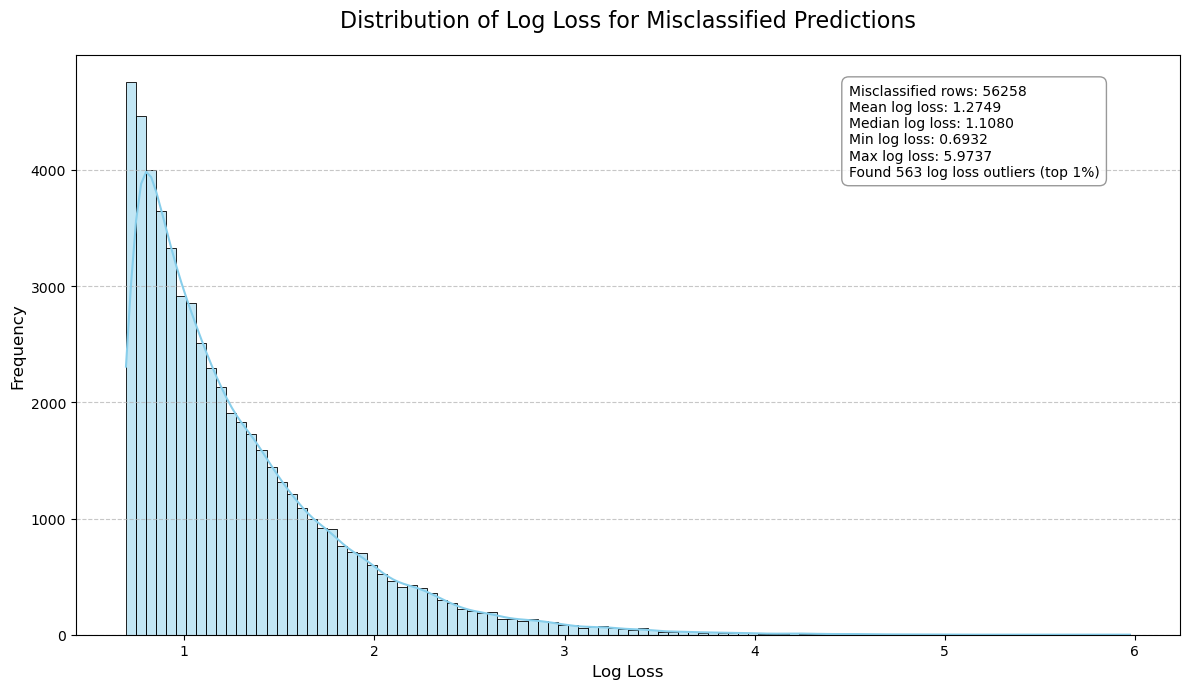

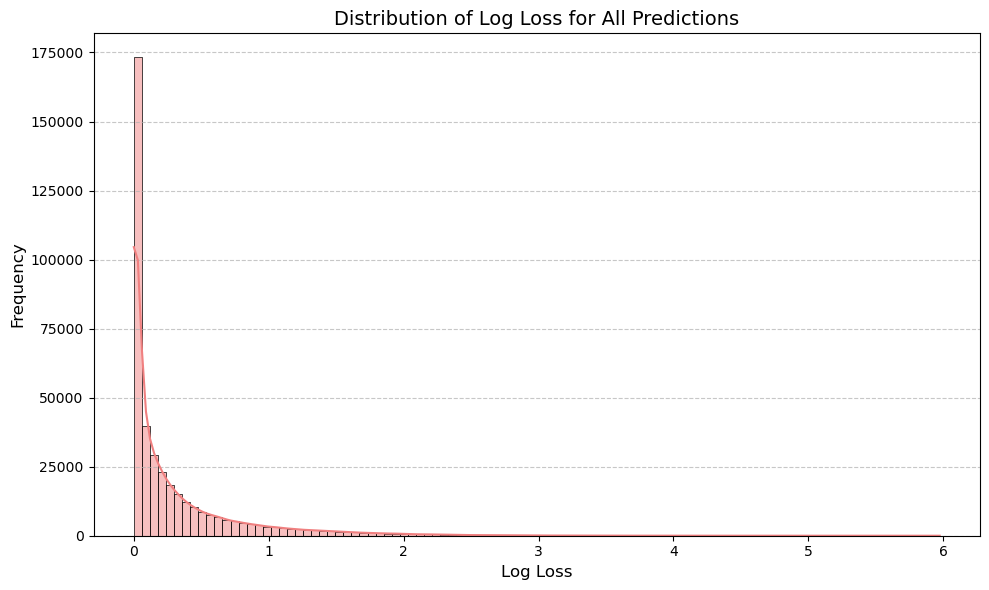

Found 563 log loss outliers (top 1%)



,question1,question2,true_is_Duplicate,predicted_is_Duplicate,predicted_proba,log_loss
327943,How can I be sure people won't steal my idea during a pitch?,How can I tell someone about a company project and make sure they won't steal my concept?,1,0,0.002545,5.973735
212773,Why must America have to interfere in Middle East conflicts? Why is America poking its nose unnecessarily in Arabia?,Why does the United states of America like poking it's nose everywhere?,1,0,0.002586,5.957572
63059,How do you spend time when waiting for the signal to turn green while waiting in traffic?,What interesting things did People do while waiting for green light?,1,0,0.002986,5.813845
262574,How can I stop being needy/clingy? How can I stop putting women on a pedestal?,How can I know when I'm putting a girl on a pedestal?,1,0,0.003006,5.807203
134020,Does the fountain of youth really exist?,Is anyone looking for or has found what is required to make the fountain of youth serum?,1,0,0.003333,5.703772
34948,Do animals or birds get bore?,Do birds get bored sometimes?,1,0,0.003517,5.650225
259152,Which is the best laptop to buy under 30000 as of March 2015 in India?,Which is the best laptop to buy under 30k?,0,1,0.996226,5.579702
318622,How do I protect single phasing of a 3 phase motor?,What is single phase and 3 phase?,1,0,0.003969,5.529213
308315,How do Imake huge profits in Nifty?,How do I predict nifty?,1,0,0.004153,5.483992
37278,Which board should I take up after my 10th?,Which subject should I take after 10th? Maths or biology?,1,0,0.004531,5.396894


In [ ]:
# Predict probabilities
probs = model.predict_proba(X)[:, 1]  # Prob for class 1

# Predicted labels
preds = (probs >= 0.5).astype(int)

# Row-wise cross entropy loss
row_losses = - (y * np.log(probs) + (1 - y) * np.log(1 - probs))

# Build DataFrame
df_predicted = pd.DataFrame({
    "question1": df["question1"].values,
    "question2": df["question2"].values,
    "true_is_Duplicate": y,
    "predicted_is_Duplicate": preds,
    "predicted_proba": probs,
    "log_loss": row_losses
})

df_misclassified = df_predicted[
    df_predicted["true_is_Duplicate"] != df_predicted["predicted_is_Duplicate"]
].sort_values(by="log_loss", ascending=False)

# Plot log loss distribution for misclassified predictions
plt.figure(figsize=(12, 7)) 
sns.histplot(df_misclassified["log_loss"], bins=100, kde=True, color='skyblue')

# Calculate statistics
misclassified_rows = len(df_misclassified)
mean_log_loss = df_misclassified['log_loss'].mean()
median_log_loss = df_misclassified['log_loss'].median()
min_log_loss = df_misclassified['log_loss'].min()
max_log_loss = df_misclassified['log_loss'].max()

# Find outliers (top 1%)
log_loss_threshold = df_misclassified['log_loss'].quantile(0.99)
num_outliers = len(df_misclassified[df_misclassified['log_loss'] >= log_loss_threshold])

plt.title("Distribution of Log Loss for Misclassified Predictions", fontsize=16, pad=20) 

text_str = (
     f"Misclassified rows: {misclassified_rows}\n"
     f"Mean log loss: {mean_log_loss:.4f}\n"
     f"Median log loss: {median_log_loss:.4f}\n"
     f"Min log loss: {min_log_loss:.4f}\n"
     f"Max log loss: {max_log_loss:.4f}\n"
     f"Found {num_outliers} log loss outliers (top 1%)")

plt.text(
    0.7, # x-coordinate 
    0.95, # y-coordinate 
    text_str,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top', 
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, edgecolor='gray') # a box for visuals
)

plt.xlabel("Log Loss", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() 
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_predicted["log_loss"], bins=100, kde=True, color='lightcoral')
plt.title("Distribution of Log Loss for All Predictions", fontsize=14)
plt.xlabel("Log Loss", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

threshold = df_misclassified["log_loss"].quantile(0.99)  # top 1% log loss
outliers = df_misclassified[df_misclassified["log_loss"] > threshold]
print(f"Found {len(outliers)} log loss outliers (top 1%)\n")
outliers[["question1", "question2", "true_is_Duplicate", "predicted_is_Duplicate", "predicted_proba", "log_loss"]].head(20)

It is our understanding that many misclassifications were actually correctly classified by the model, but misclassified in the labeled data.

## Step 4: Model Optimization
To further improve performance, we perform hyperparameter tuning using Optuna. This step searches for the best model parameters to minimize log loss and maximize accuracy.

In [ ]:
def objective(trial):
    params = {
         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
         'max_depth': trial.suggest_int('max_depth', 3, 12),
         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
         'gamma': trial.suggest_float('gamma', 0, 5),
         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
         'random_state': 42,
         'eval_metric': 'logloss'
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X, y, cv=5, scoring='neg_log_loss').mean()
    return score

# Run the study
study = optuna.create_study(direction='maximize')  # log_loss is negated, so we maximize neg_log_loss
n_trials = 50
with tqdm(total=n_trials) as pbar:
    def callback(study, trial):
        pbar.update(1)

    study.optimize(objective, n_trials=n_trials, callbacks=[callback])

# Best parameters and best score
print("Best parameters:", study.best_params)
print("Best score (neg log loss):", study.best_value)


[I 2025-06-29 00:56:51,287] A new study created in memory with name: no-name-f4bbb043-dca8-48d1-ab42-f68f9f91eedf


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-29 00:57:32,142] Trial 0 finished with value: -0.31590874254489776 and parameters: {'n_estimators': 275, 'max_depth': 11, 'learning_rate': 0.07440490054356015, 'subsample': 0.5211917803669079, 'gamma': 1.81213152576513, 'reg_alpha': 0.005982992179625151, 'reg_lambda': 1.176956549031021e-07}. Best is trial 0 with value: -0.31590874254489776.
[I 2025-06-29 00:58:11,773] Trial 1 finished with value: -0.3301863251537218 and parameters: {'n_estimators': 847, 'max_depth': 11, 'learning_rate': 0.1704005524801936, 'subsample': 0.7087634617052654, 'gamma': 1.8657809984377627, 'reg_alpha': 4.102706915826905e-07, 'reg_lambda': 1.3791850129650207e-06}. Best is trial 0 with value: -0.31590874254489776.
[I 2025-06-29 00:58:24,173] Trial 2 finished with value: -0.32399152210268806 and parameters: {'n_estimators': 111, 'max_depth': 9, 'learning_rate': 0.03327868705651745, 'subsample': 0.8887600903223983, 'gamma': 2.4168456539538767, 'reg_alpha': 0.45488612691657104, 'reg_lambda': 0.07792422

Best parameters: {'n_estimators': 999, 'max_depth': 11, 'learning_rate': 0.0243140758876079, 'subsample': 0.7980501604331169, 'gamma': 1.929412973256618, 'reg_alpha': 0.13024276872258336, 'reg_lambda': 0.02331213302369224}
Best score (neg log loss): -0.31015691374986376


We conclude that with hyperparameter tuning, the model can achieve a log loss of 0.31.

# Conclusion
This notebook implemented a full pipeline for duplicate question detection, from feature engineering to model training, evaluation and optimization. The results provide a foundation for further improvements, such as advanced feature engineering, ensembling, or error-driven data augmentation. The quality of the labeled data is still under question, and we feel that further enrichment and correction might offer even better model performance.